# Тестирование качества работы моделей машинного обучения

## Установка зависимостей

In [116]:
!pip install numpy matplotlib scikit-learn pytest


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Импорт пакетов

In [117]:
%%writefile app.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Writing app.py


In [118]:
import matplotlib.pyplot as plt

## Генерация датасетов

In [119]:
%%writefile -a app.py

def generate_dataset(noise=False, outlier=False):
    xs = np.linspace(0, 10, 100).reshape(-1, 1)
    ys = xs.flatten() + np.random.random(100) * 2 - 1
    
    if outlier:
        ys[25:45] *= 2
    if noise:
        ys += np.random.normal(0, 3, 100)
        
    return xs, ys

Appending to app.py


In [120]:
import importlib
import app
importlib.reload(app)
from app import generate_dataset

datasets = {
    "clean": generate_dataset(),
    "with_outliers": generate_dataset(outlier=True),
    "with_noise": generate_dataset(noise=True)
}

## Визуализация датасетов

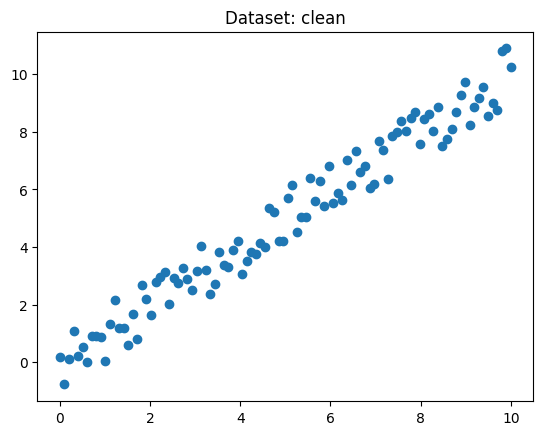

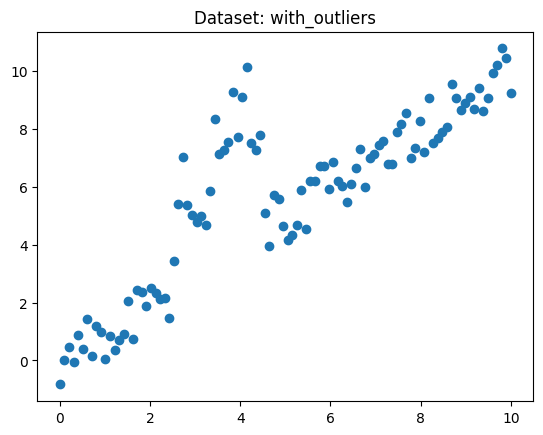

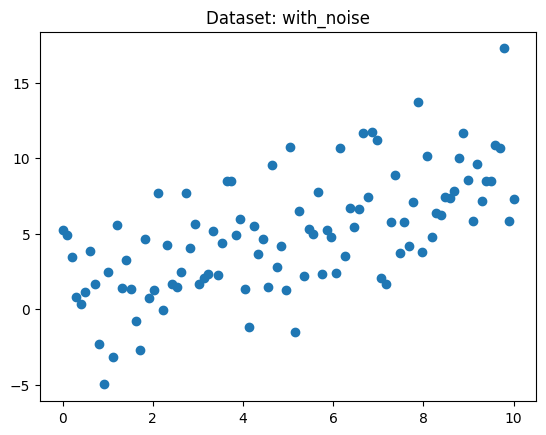

In [121]:
for name, (xs, ys) in datasets.items():
    plt.scatter(xs, ys)
    plt.title(f"Dataset: {name}")
    plt.show()

## Обучение модели на чистом датасете

In [122]:
%%writefile -a app.py

def train_model(x_train, y_train):
    return LinearRegression().fit(x_train, y_train)

Appending to app.py


In [123]:
import importlib
import app
importlib.reload(app)
from app import train_model

model = train_model(*datasets["clean"])

## Оценка модели на разных датасетах

In [124]:
%%writefile -a app.py

def evaluate_model(model, x_test, y_test):
    return mean_squared_error(y_test, model.predict(x_test))

Appending to app.py


In [125]:
import importlib
import app
importlib.reload(app)
from app import evaluate_model

def test_model_performance(x_test, y_test, name, threshold=5):
    mse = evaluate_model(model, x_test, y_test)
    
    print(f"Dataset: {name} | MSE: {mse}")
    
    return mse <= threshold

In [126]:
test_results = {
    name: test_model_performance(x, y, name) for name, (x, y) in datasets.items()
}

print("Результаты тестов:")

for dataset, result in test_results.items():
    status = "Пройден ✅" if result else "Не пройден ❌"
    
    print(f"{dataset}: {status}")

Dataset: clean | MSE: 0.347814566925488
Dataset: with_outliers | MSE: 2.863692741973637
Dataset: with_noise | MSE: 9.16817016213995
Результаты тестов:
clean: Пройден ✅
with_outliers: Пройден ✅
with_noise: Не пройден ❌


## Сохранение тестов в файл `test_app.py`

In [127]:
%%writefile test_app.py
import pytest
import app

@pytest.fixture
def datasets():
    return {
        "clean": app.generate_dataset(),
        "with_outliers": app.generate_dataset(outlier=True),
        "with_noise": app.generate_dataset(noise=True)
    }

@pytest.fixture
def trained_model(datasets):
    x_train, y_train = datasets["clean"]
    
    return app.train_model(x_train, y_train)

def test_clean_data_performance(trained_model, datasets):
    x_test, y_test = datasets["clean"]
    mse = app.evaluate_model(trained_model, x_test, y_test)
    
    assert mse < 5, f"MSE слишком высока для чистых данных (clean dataset): {mse}"

def test_outlier_data_performance(trained_model, datasets):
    x_test, y_test = datasets["with_outliers"]
    mse = app.evaluate_model(trained_model, x_test, y_test)
    
    assert mse < 10, f"MSE слишком высока для данных с выбросами (with_outliers dataset): {mse}"

def test_noisy_data_performance(trained_model, datasets):
    x_test, y_test = datasets["with_noise"]
    mse = app.evaluate_model(trained_model, x_test, y_test)
    
    assert mse > 5, "MSE неожиданно низкий для шумных данных (with_noise dataset). Должен быть высоким для обнаружения плохой производительности"

Writing test_app.py


## Запуск тестов с помощью pytest

In [128]:
!pytest test_app.py -v

============================= test session starts ==============================
platform darwin -- Python 3.13.0, pytest-8.3.5, pluggy-1.5.0 -- /Users/adiukarev/PycharmProjects/urfu_AutoML/.venv/bin/python
cachedir: .pytest_cache
rootdir: /Users/adiukarev/PycharmProjects/urfu_AutoML/lab5
plugins: anyio-4.9.0
collected 3 items                                                              

test_app.py::test_clean_data_performance PASSED                          [ 33%]
test_app.py::test_outlier_data_performance PASSED                        [ 66%]
test_app.py::test_noisy_data_performance PASSED                          [100%]

============================== 3 passed in 0.47s ===============================
